In [1]:
#라이브러리불러오기
import pandas as pd
import numpy as np
from konlpy.tag import Twitter
from konlpy.utils import pprint
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
#크롤링 결과 열어서 포스팅 단위로 불리 저장
doc =open('뚝섬역.csv')
data = doc.read()
doc.close()
phrase = data.split('\n')

In [3]:
#포스팅에서 한글 외 문자 제거
import re
hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')


In [4]:
#형태소 문장 단위 추출
dic_Twitter = []
for i in range(len(phrase)):
    p = hangul.sub(' ', phrase[i])
    s = Twitter().pos(p, stem=True, norm=True)  ##norm, stem 옵션 추가
    dic_Twitter.append(s)
print(dic_Twitter[:3])

[[('아아', 'Noun'), ('점심', 'Noun'), ('부터', 'Josa'), ('삼겹살', 'Noun'), ('무한리필', 'Noun'), ('흡입', 'Noun'), ('하다', 'Verb'), ('치아', 'Noun'), ('씨드', 'Noun'), ('를', 'Josa'), ('분명', 'Noun'), ('방금', 'Noun'), ('마켓', 'Noun'), ('에서', 'Josa'), ('사다', 'Verb'), ('말', 'Noun'), ('이지', 'Noun'), ('오늘', 'Noun'), ('도', 'Josa'), ('늦다', 'Verb'), ('일', 'Noun'), ('하니', 'Noun'), ('먹다', 'Verb'), ('뭐', 'Noun'), ('삼겹살', 'Noun'), ('고기', 'Noun'), ('무한리필', 'Noun'), ('치아', 'Noun'), ('씨드', 'Noun'), ('냠냠', 'Adverb'), ('다이어트', 'Noun'), ('셀카', 'Noun'), ('뚝섬역', 'Noun'), ('성수동', 'Noun'), ('맛집', 'Noun'), ('공감', 'Noun'), ('인친', 'Noun'), ('맞팔', 'Noun'), ('소통', 'Noun'), ('가을', 'Noun')], [('호박고구마', 'Noun'), ('파운드', 'Noun'), ('케익', 'Noun'), ('소량', 'Noun'), ('준비', 'Noun'), ('되다', 'Verb'), ('있다', 'Adjective'), ('제', 'Noun'), ('스타일', 'Noun'), ('대로', 'Josa'), ('담', 'Noun'), ('백', 'Suffix'), ('하다', 'Verb'), ('커피', 'Noun'), ('식탁', 'Noun'), ('성수동', 'Noun'), ('카페', 'Noun'), ('뚝섬역', 'Noun'), ('카페', 'Noun'), ('성수동', 'Noun'), ('뚝섬역', 'Noun'), 

In [5]:
#형용사와 명사 단어만 문장별로 추출
dic_ad_noun=[]
for twit in dic_Twitter:
    c = [x[0] for x in twit if x[1] =="Adjective" or x[1] == "Noun"]
    dic_ad_noun.append(c)
print(dic_ad_noun[:3])

[['아아', '점심', '삼겹살', '무한리필', '흡입', '치아', '씨드', '분명', '방금', '마켓', '말', '이지', '오늘', '일', '하니', '뭐', '삼겹살', '고기', '무한리필', '치아', '씨드', '다이어트', '셀카', '뚝섬역', '성수동', '맛집', '공감', '인친', '맞팔', '소통', '가을'], ['호박고구마', '파운드', '케익', '소량', '준비', '있다', '제', '스타일', '담', '커피', '식탁', '성수동', '카페', '뚝섬역', '카페', '성수동', '뚝섬역', '서울숲', '서울숲', '역', '호박고구마', '파운드', '고구마', '맛', '계절', '내일', '연남', '점'], ['사무실', '카페', '용', '커피', '머신', '있다', '이상하다', '자꾸', '밖', '사마', '시', '직원', '포장', '오늘', '내일', '주말', '성수동', '뚝섬역', '사무실', '커피', '아메리카노']]


# word2vec으로 단어과 가까운 단어 출력해보기

In [6]:
#word2vec으로 단어를 공간에 뿌리기 
#size는 차원의 크기, 결과를 보고 결정하자
w2v = models.Word2Vec(dic_ad_noun, size=100)

# K means로 클러스터링 해보기

In [9]:
#K means 시각화
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:\\Windows\\Fonts\\malgun.ttf").get_name()
rc('font', family=font_name)
flist = matplotlib.font_manager.get_fontconfig_fonts()

C:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [10]:
#K means를 위해  TSNE로 다차원상에 있는 데이터를 평면에 흩어지게 표현
from sklearn.manifold import TSNE
tsne = TSNE()
textplot = tsne.fit_transform(w2v[w2v.index2word])

In [11]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [12]:
#목적함수(목적하는 분류단위, K)가 없을 때, K maens에 사용할 최적화된 K를 찾는다. 클러스터 내 분산과 외에 분산의 관계를 고려하여
k_range = range(1,50)
k_means_var = [KMeans(n_clusters=k).fit(textplot) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]

from scipy.spatial.distance import cdist, pdist

k_euclid = [cdist(textplot, cent, 'euclidean') for cent in centroids]

dist = [np.min(ke, axis=1) for ke in k_euclid]

wcss = [sum(d**2) for d in dist]

tss = sum(pdist(textplot)**2) / np.array(textplot).shape[0]

bss = tss - wcss

(0, 20)

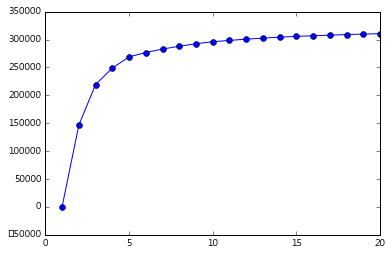

In [13]:
#K에 따른 결과 그래프로 표현
#이 경우에는 10이상에서는 결과가 거의 변하지 않기 때문에 8~10정도의 k를 사용하면 좋다
plt.plot(k_range, bss, marker="o")
plt.xlim((0,20))  #X축 범위